In [26]:
## Model: Baseline & Random Forest
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve
from scipy.stats import chi2_contingency

In [3]:
from google.colab import files

# Upload the file manually
uploaded = files.upload()

Saving hypertension_stroke_data.csv to hypertension_stroke_data.csv


In [4]:
# Load the uploaded CSV file
import pandas as pd
pt = pd.read_csv(list(uploaded.keys())[0])

In [5]:
# Summary
print(pt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74165 entries, 0 to 74164
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subject_id                74165 non-null  int64  
 1   hadm_id                   74165 non-null  int64  
 2   admittime                 74165 non-null  object 
 3   dischtime                 74165 non-null  object 
 4   deathtime                 74165 non-null  object 
 5   hypertension_criteria     74165 non-null  object 
 6   gender                    74165 non-null  object 
 7   age                       74165 non-null  int64  
 8   race                      74165 non-null  object 
 9   anchor_year_group         74165 non-null  object 
 10  heart_rate                74165 non-null  float64
 11  systolic_bp               74165 non-null  float64
 12  diastolic_bp              74165 non-null  float64
 13  temperature               74165 non-null  float64
 14  resp_r

In [6]:
# Step 1: Data Preprocessing
# Drop irrelevant columns (such as IDs and timestamps that won't be used for prediction)
pt = pt.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'hypertension_criteria', 'gender',
                      'anchor_year_group', 'stroke_admittime', 'hypertensive_admittime', 'time_to_stroke_days'])

# Handle categorical and numerical columns
categorical_columns = ['race', 'medications_administered', 'all_icd_codes']
numerical_columns = ['age', 'heart_rate', 'systolic_bp', 'diastolic_bp', 'temperature', 'resp_rate', 'oxygen_saturation',
                     'glucose', 'diabetes', 'chronic_kidney_disease', 'heart_failure']

# Separate features and target variable
X = pt.drop(columns=['has_stroke'])
y = pt['has_stroke']

# Step 2: Handle missing values and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_columns),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_columns)
    ])

# Preprocess the data (transform the categorical and numerical features)
X_preprocessed = preprocessor.fit_transform(X)

In [7]:
# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.1, random_state=42, stratify=y)

# Step 4: Handle Imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Step 5: Scale the data (adjusted for sparse matrices)
scaler = StandardScaler(with_mean=False)
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      6478
           1       0.60      0.61      0.60       939

    accuracy                           0.90      7417
   macro avg       0.77      0.77      0.77      7417
weighted avg       0.90      0.90      0.90      7417

Confusion Matrix - Logistic Regression:
[[6092  386]
 [ 368  571]]
ROC-AUC Score - Logistic Regression: 0.8630728037979615


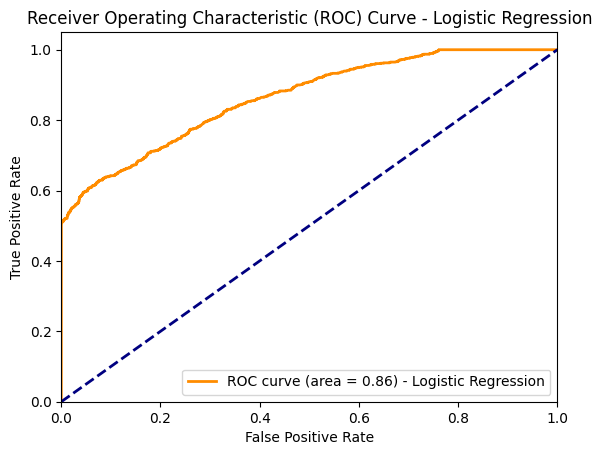

In [8]:
## Baseline: Logistic Regression
# Step 6-1: Logistic Regression Baseline Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Define the Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Fit the model on the scaled, resampled training data
lr_model.fit(X_train_res_scaled, y_train_res)

# Step 7-1: Evaluate the Logistic Regression model
y_pred_lr = lr_model.predict(X_test_scaled)

# Classification Report
print("Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
print("Confusion Matrix - Logistic Regression:")
print(confusion_matrix(y_test, y_pred_lr))

# Step 8-1: ROC-AUC Score
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"ROC-AUC Score - Logistic Regression: {roc_auc_lr}")

# Step 9-1: Plot the ROC Curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lr:.2f}) - Logistic Regression')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [9]:
## Random Forest
# Step 6-2: Build and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_res_scaled, y_train_res)

# Step 7-2: Evaluate the model
y_pred = rf_model.predict(X_test_scaled)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      6478
           1       1.00      0.51      0.67       939

    accuracy                           0.94      7417
   macro avg       0.97      0.75      0.82      7417
weighted avg       0.94      0.94      0.93      7417

Confusion Matrix:
[[6478    0]
 [ 463  476]]


ROC-AUC Score: 0.808663368208479


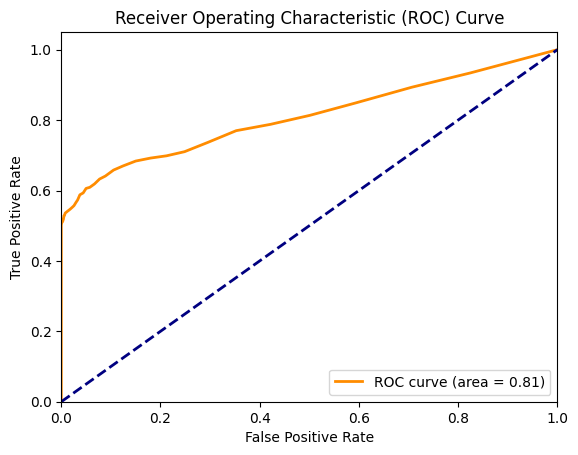

In [10]:
# Step 8-2: ROC-AUC Score
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

# Step 9-2: Plot the ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

                                                 Feature  Importance
39                                            race_WHITE    0.040125
9                                 chronic_kidney_disease    0.039359
8                                               diabetes    0.025357
2                                            systolic_bp    0.024518
3                                           diastolic_bp    0.021806
0                                                    age    0.021764
7                                                glucose    0.019243
4                                            temperature    0.018956
38                                          race_UNKNOWN    0.016761
5                                              resp_rate    0.016656
1                                             heart_rate    0.016573
6                                      oxygen_saturation    0.016474
18                           race_BLACK/AFRICAN AMERICAN    0.012666
10                                

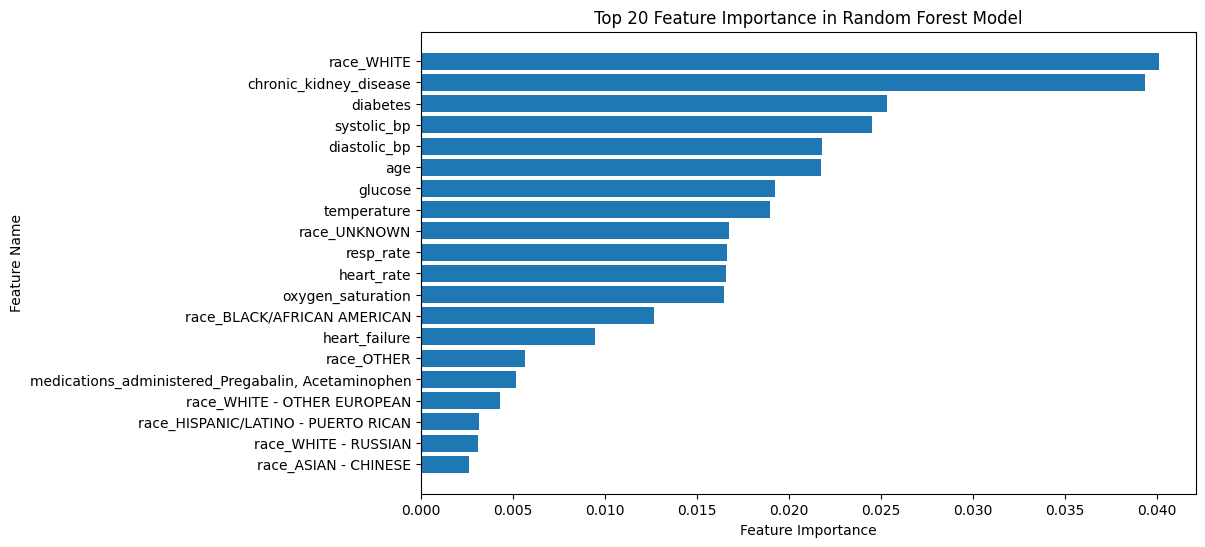

In [11]:
# Step 10: Get and plot feature importance for Random Forest
# Set the number of top features to display
N = 20

# Get the feature names from the ColumnTransformer
numerical_features = numerical_columns
categorical_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_columns)
all_features = np.concatenate([numerical_features, categorical_features])

# Get the feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})

# Sort the DataFrame by importance and select the top N features
top_features_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(N)

# Print the top N most important features
print(top_features_df)

# Plot the top N feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features_df['Feature'], top_features_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title(f'Top {N} Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()

<ipython-input-29-fcfed0aeb4bb>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=race_stroke.index, y=race_stroke['stroke_rate'], palette='viridis', hue=None)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning

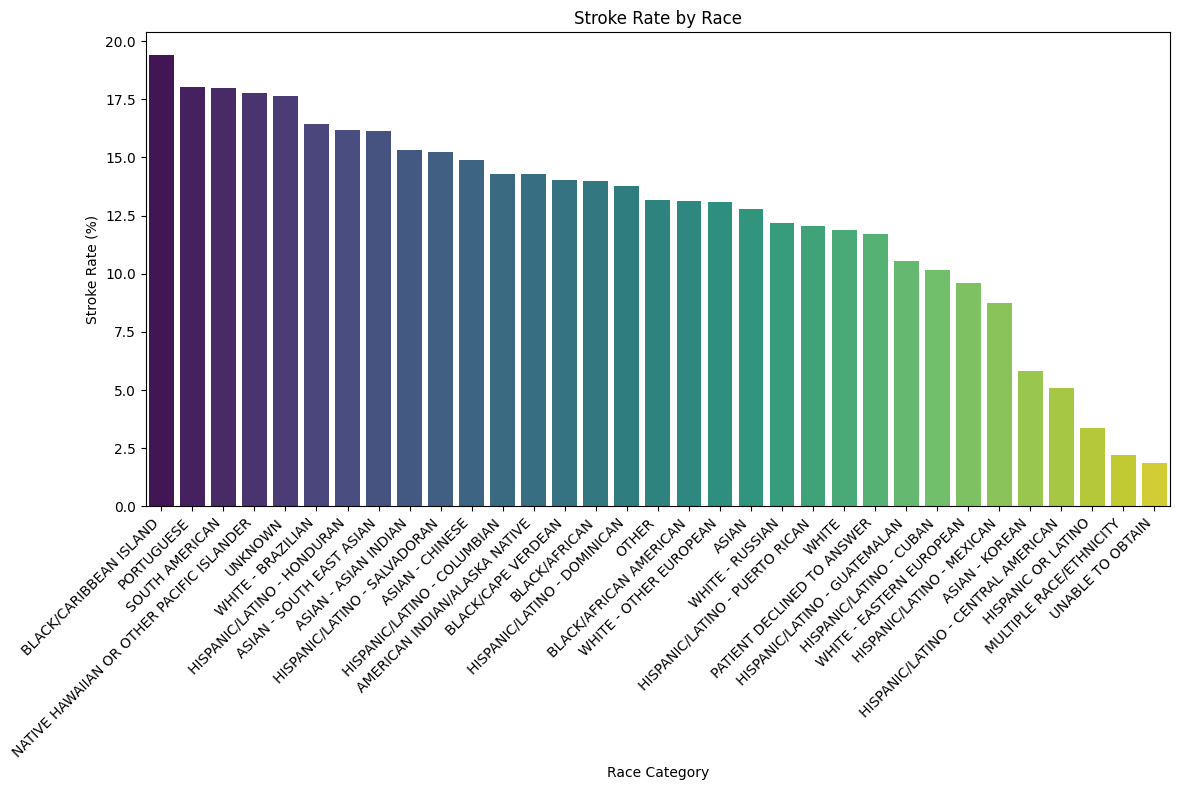

Chi-square test for race: p-value=5.797176633146861e-47


In [29]:
## Analyze Key Features: dive deeper into the top features.
# 1. Check relationship between race and stroke
race_stroke = pt.groupby(['race', 'has_stroke']).size().unstack().fillna(0)
race_stroke['stroke_rate'] = race_stroke[1] / (race_stroke[0] + race_stroke[1]) * 100

# Sort by stroke rate to make the plot more readable
race_stroke = race_stroke.sort_values(by='stroke_rate', ascending=False)

# Plot the stroke rate by race (fix warning by setting hue=None)
plt.figure(figsize=(12, 8))  # Increased figure size to prevent compactness
sns.barplot(x=race_stroke.index, y=race_stroke['stroke_rate'], palette='viridis', hue=None)
plt.title('Stroke Rate by Race')
plt.ylabel('Stroke Rate (%)')
plt.xlabel('Race Category')
plt.xticks(rotation=45, ha='right')  # Rotate and adjust text alignment
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Chi-square test for race and stroke
race_chi2, race_p, race_dof, race_ex = chi2_contingency(pd.crosstab(pt['race'], pt['has_stroke']))
print(f'Chi-square test for race: p-value={race_p}')

<ipython-input-30-0004baa6ac69>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ckd_stroke.index, y=ckd_stroke['stroke_rate'], palette='coolwarm', hue=None)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


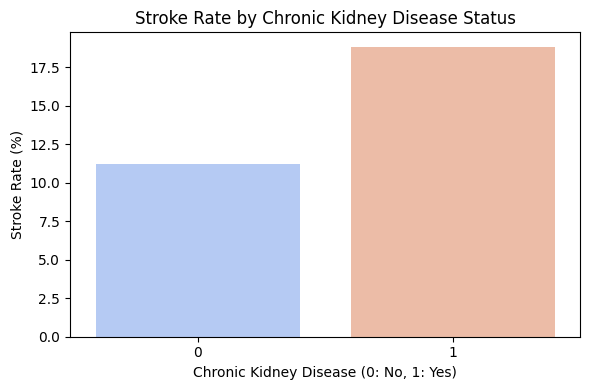

Chi-square test for chronic_kidney_disease: p-value=1.5122237922016158e-134


In [30]:
# 2. Check relationship between chronic_kidney_disease and stroke
ckd_stroke = pt.groupby(['chronic_kidney_disease', 'has_stroke']).size().unstack().fillna(0)
ckd_stroke['stroke_rate'] = ckd_stroke[1] / (ckd_stroke[0] + ckd_stroke[1]) * 100

# Plot the stroke rate by chronic kidney disease status
plt.figure(figsize=(6, 4))
sns.barplot(x=ckd_stroke.index, y=ckd_stroke['stroke_rate'], palette='coolwarm', hue=None)
plt.title('Stroke Rate by Chronic Kidney Disease Status')
plt.ylabel('Stroke Rate (%)')
plt.xlabel('Chronic Kidney Disease (0: No, 1: Yes)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Chi-square test for chronic kidney disease and stroke
ckd_chi2, ckd_p, ckd_dof, ckd_ex = chi2_contingency(pd.crosstab(pt['chronic_kidney_disease'], pt['has_stroke']))
print(f'Chi-square test for chronic_kidney_disease: p-value={ckd_p}')

<ipython-input-31-e7392ac61dad>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diabetes_stroke.index, y=diabetes_stroke['stroke_rate'], palette='coolwarm', hue=None)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


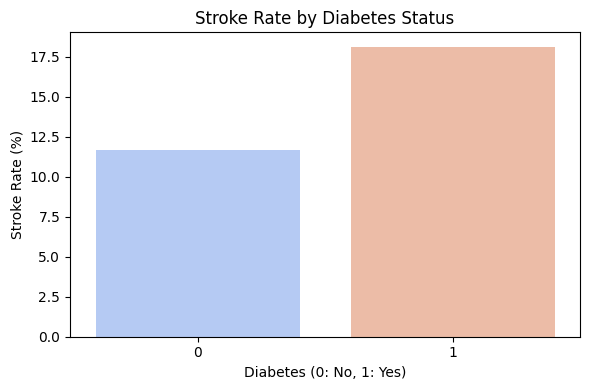

Chi-square test for diabetes: p-value=3.4490401582764757e-79


In [31]:
# 3. Check relationship between diabetes and stroke
diabetes_stroke = pt.groupby(['diabetes', 'has_stroke']).size().unstack().fillna(0)
diabetes_stroke['stroke_rate'] = diabetes_stroke[1] / (diabetes_stroke[0] + diabetes_stroke[1]) * 100

# Plot the stroke rate by diabetes status
plt.figure(figsize=(6, 4))
sns.barplot(x=diabetes_stroke.index, y=diabetes_stroke['stroke_rate'], palette='coolwarm', hue=None)
plt.title('Stroke Rate by Diabetes Status')
plt.ylabel('Stroke Rate (%)')
plt.xlabel('Diabetes (0: No, 1: Yes)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Chi-square test for diabetes and stroke
diabetes_chi2, diabetes_p, diabetes_dof, diabetes_ex = chi2_contingency(pd.crosstab(pt['diabetes'], pt['has_stroke']))
print(f'Chi-square test for diabetes: p-value={diabetes_p}')

<ipython-input-32-ccdb16a5b135>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_stroke = pt.groupby([age_bins, 'has_stroke']).size().unstack().fillna(0)
<ipython-input-32-ccdb16a5b135>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_stroke.index.astype(str), y=age_stroke['stroke_rate'], palette='Blues')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-pa

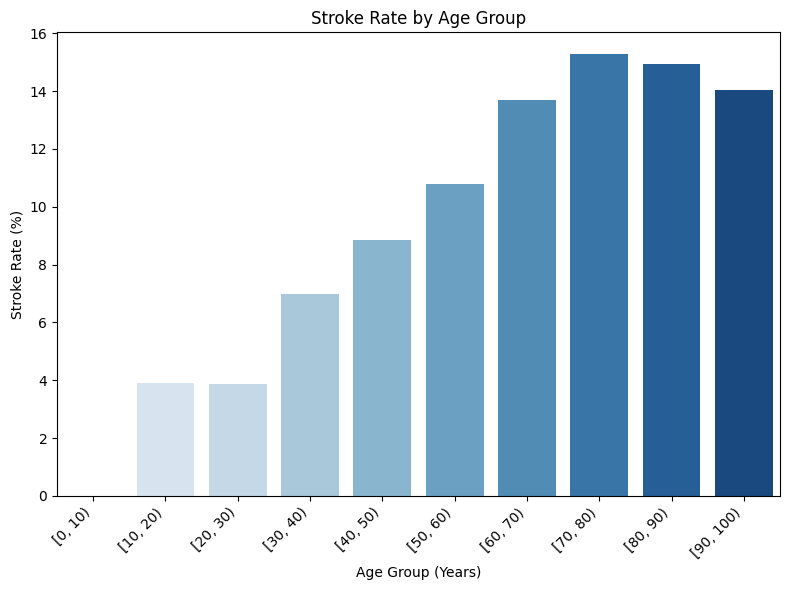

Chi-square test for age: p-value=4.591056461195946e-116


In [32]:
# 4. Check relationship between age and stroke

# Define age bins (10-year intervals)
age_bins = pd.cut(pt['age'], bins=range(0, 101, 10), right=False)

# Group by the age bins and stroke status
age_stroke = pt.groupby([age_bins, 'has_stroke']).size().unstack().fillna(0)
age_stroke['stroke_rate'] = age_stroke[1] / (age_stroke[0] + age_stroke[1]) * 100

# Plot the stroke rate by age group
plt.figure(figsize=(8, 6))
sns.barplot(x=age_stroke.index.astype(str), y=age_stroke['stroke_rate'], palette='Blues')
plt.title('Stroke Rate by Age Group')
plt.ylabel('Stroke Rate (%)')
plt.xlabel('Age Group (Years)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Chi-square test for age and stroke
age_chi2, age_p, age_dof, age_ex = chi2_contingency(pd.crosstab(age_bins, pt['has_stroke']))
print(f'Chi-square test for age: p-value={age_p}')